<a href="https://colab.research.google.com/github/Jhonsep/IMPLEMENTACION_TESIS_DRON/blob/main/.notebooks%5Ctraining_A1_OTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de A1

## First Training OTA

### Settings

In [ ]:
# import Librarys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
import math
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Image, clear_output # Para mostrar imágenes en Colab/Jupyter
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model, saving
import tensorflow.keras.backend as K
import os
import time
from google.colab import drive
# Montar Google Drive
try:
    drive.mount('/content/drive')
    print("✅ Google Drive montado exitosamente.")
except Exception as e:
    print(f"❌ Error al montar Drive: {e}. Intente recargar la página.")

# Definir la ruta de la carpeta del proyecto DENTRO de Drive
# **ASEGÚRATE DE QUE ESTA RUTA COINCIDA CON LA UBICACIÓN DE TU CARPETA**
RUTA_PROYECTO_DRIVE = '/content/drive/MyDrive/Implementacion_Tesis_Drones'

# Cambiar el directorio de trabajo al proyecto
if os.path.isdir(RUTA_PROYECTO_DRIVE):
    %cd {RUTA_PROYECTO_DRIVE}
    print(f"✅ Directorio de trabajo cambiado a: {os.getcwd()}")
else:
    print(f"❌ Error: La carpeta '{RUTA_PROYECTO_DRIVE}' no fue encontrada.")
    print("Asegúrese de que la carpeta compartida esté en la raíz de su Drive.")

# =========================================================




❌ Error al montar Drive: Error: credential propagation was unsuccessful. Intente recargar la página.
/content/drive/MyDrive/Implementacion_Tesis_Drones
✅ Directorio de trabajo cambiado a: /content/drive/MyDrive/Implementacion_Tesis_Drones


### Definición del Offset Tracking Autoencoder (OTA)

In [ ]:
# --- 1. Definición del Autoencoder de Seguimiento de Offset (Debe coincidir con el modelo guardado) ---

# Dimensiones del ROI
roi_height = 160
roi_width = 240
input_vector_size = roi_height * roi_width

# Dimensiones de la capa oculta (espacio latente)
latent_dimensions = 51

# Dimensiones de la capa de salida (para el offset tracking)
output_dimensions = 22 # 11 para X y 11 para Y

# Registra la clase para poder cargarla correctamente con tf.keras.models.load_model
@keras.saving.register_keras_serializable(package="MyModels")
class OffsetTrackingAutoencoder(Model):
  def __init__(self, latent_dim, output_dim, input_shape, **kwargs):
    super(OffsetTrackingAutoencoder, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.input_shape_ = input_shape

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      layers.Flatten(),
      layers.Dense(self.latent_dim, activation='relu')
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(self.output_dim, activation='sigmoid')
    ])

  def build(self, input_shape):
      # Definimos el input_shape_ aqui para que el get_config pueda usarlo
      self.input_shape_ = input_shape
      self.encoder.build(input_shape)
      input_shape = self.encoder.compute_output_shape(input_shape)
      self.decoder.build(input_shape)
      super().build(input_shape)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  # Este método es necesario para la serialización de la configuración
  def get_config(self):
    config = super(OffsetTrackingAutoencoder, self).get_config()
    config.update({
        'latent_dim': self.latent_dim,
        'output_dim': self.output_dim,
        # self.input_shape_ se inicializa en el método build
        'input_shape': self.input_shape_[1:]
    })
    return config

  @classmethod
  def from_config(cls, config):
      # Remueve 'input_shape' del config para evitar un error de kwargs en el constructor
      input_shape = config.pop('input_shape', None)
      return cls(input_shape=input_shape, **config)

# Crea una instancia nueva si ocurre otro tipo de error
autoencoder_drone = OffsetTrackingAutoencoder(
  latent_dim=latent_dimensions,
  output_dim=output_dimensions,
  input_shape=(roi_height, roi_width, 1)
    )

# Opcional: Construir el modelo para ver el resumen de las capas
autoencoder_drone.build(input_shape=(None, roi_height, roi_width, 1))
print("Resumen del modelo Autoencoder:")
autoencoder_drone.summary()

Resumen del modelo Autoencoder:


Model: "offset_tracking_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 51)             │     1,958,451 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 22)             │         1,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959,595 (7.48 MB)

 Trainable params: 1,959,595 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

### Compilar el Modelo

In [ ]:

print("\nCompilando el modelo Autoencoder...")
autoencoder_drone.compile(optimizer='adam',
                          loss='binary_crossentropy', # Adecuado para clasificación multietiqueta
                          metrics=['BinaryAccuracy']) # Añadir la métrica personalizada

print("Modelo compilado exitosamente.")


Compilando el modelo Autoencoder...
Modelo compilado exitosamente.


### Generar el Dataset

In [ ]:

# --- 2. Generar el Dataset de Entrenamiento con Bordes Canny ---

# Ruta de la imagen única a utilizar para el entrenamiento
image_path = './images/dron/0029(1).jpg'
output_image_size = (240, 160) # Tamaño de tu imagen redimensionada (imagen completa)

try:
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen de {image_path}. Creando una imagen de ejemplo.")

    img_resize = cv2.resize(original_img, output_image_size)

except FileNotFoundError:
    print("Creando una imagen de ejemplo (blanca) para la demostración y entrenamiento.")
    img_resize = np.ones((output_image_size[1], output_image_size[0], 3), dtype=np.uint8) * 255
except Exception as e:
    print(f"Error al cargar/procesar la imagen, creando una de ejemplo: {e}")
    img_resize = np.ones((output_image_size[1], output_image_size[0], 3), dtype=np.uint8) * 255

# Centro 'verdadero' del dron en la imagen redimensionada (ajusta según tu imagen 0029(1).jpg)
drone_true_center_x = 120
drone_true_center_y = 80

# Parámetros para Canny Edge Detection
low_threshold = 50
high_threshold = 150

# Rango de offsets para dx y dy.
min_offset = -5
max_offset = 5

# Listas para almacenar los datos de entrenamiento
X_train_list = [] # Para las imágenes ROI con bordes Canny
y_train_list = [] # Para las etiquetas de offset (vector de 22)

# Función para mapear un offset (ej. -5 a 5) a un índice (0 a 10)
def map_offset_to_index(offset_value, min_val):
    return offset_value - min_val

# Función inversa para mapear un índice (0 a 10) a un offset (-5 a 5)
def map_index_to_offset(index_value, min_val):
    return index_value + min_val

print("\nComenzando la generación del dataset con imágenes de bordes Canny...")

# Iterar sobre todas las posibles combinaciones de dx y dy (11x11 = 121 muestras)
for dx in range(min_offset, max_offset + 1):
    for dy in range(min_offset, max_offset + 1):
        # Calcular el centro del ROI para esta instancia
        roi_center_x = drone_true_center_x - dx
        roi_center_y = drone_true_center_y - dy

        # Calcular las coordenadas de la esquina superior izquierda (x1, y1) y
        # la esquina inferior derecha (x2, y2) del ROI.
        x1_roi = int(roi_center_x - roi_width / 2)
        y1_roi = int(roi_center_y - roi_height / 2)
        x2_roi = int(roi_center_x + roi_width / 2)
        y2_roi = int(roi_center_y + roi_height / 2)

        # Asegurarse de que el ROI esté dentro de los límites de la imagen grande
        x1_bounded = max(0, x1_roi)
        y1_bounded = max(0, y1_roi)
        x2_bounded = min(img_resize.shape[1], x2_roi) # Ancho de la imagen
        y2_bounded = min(img_resize.shape[0], y2_roi) # Alto de la imagen

        # Extraer el ROI de la imagen redimensionada
        ROI_extracted = img_resize[y1_bounded:y2_bounded, x1_bounded:x2_bounded]

        # Asegurarse de que el ROI tenga el tamaño EXACTO deseado (roi_width, roi_height)
        if ROI_extracted.shape[0] != roi_height or ROI_extracted.shape[1] != roi_width:
            ROI_final = cv2.resize(ROI_extracted, (roi_width, roi_height))
        else:
            ROI_final = ROI_extracted

        # Convertir a escala de grises para Canny
        ROI_gray = cv2.cvtColor(ROI_final, cv2.COLOR_BGR2GRAY)

        # Aplicar Canny Edge Detection
        edges = cv2.Canny(ROI_gray, low_threshold, high_threshold)

        # Normalizar los píxeles de los bordes a un rango de 0 a 1
        edges_normalized = edges.astype('float32') / 255.0

        # Añadir la dimensión del canal (1) para Keras (height, width, 1)
        edges_input = np.expand_dims(edges_normalized, axis=-1)

        X_train_list.append(edges_input)

        # --- Crear la etiqueta y_train (vector de 22) ---
        # Mapear dx y dy a un índice de 0 a 10
        offset_index_x = map_offset_to_index(dx, min_offset)
        offset_index_y = map_offset_to_index(dy, min_offset)

        # Crear el vector one-hot de 22 elementos
        label_vector = np.zeros(output_dimensions, dtype='float32')
        label_vector[offset_index_x] = 1.0        # Activa la neurona para el offset X
        label_vector[11 + offset_index_y] = 1.0   # Activa la neurona para el offset Y

        y_train_list.append(label_vector)

# Convertir las listas a arrays de NumPy al final
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Número de muestras generadas
num_samples = len(X_train_list)

print(f"Dataset de bordes Canny generado.")
print(f"Número de muestras generadas: {num_samples}") # Debería ser 121
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")


Comenzando la generación del dataset con imágenes de bordes Canny...
Dataset de bordes Canny generado.
Número de muestras generadas: 121
Forma de X_train: (121, 160, 240, 1)
Forma de y_train: (121, 22)


### Entrenar Modelo

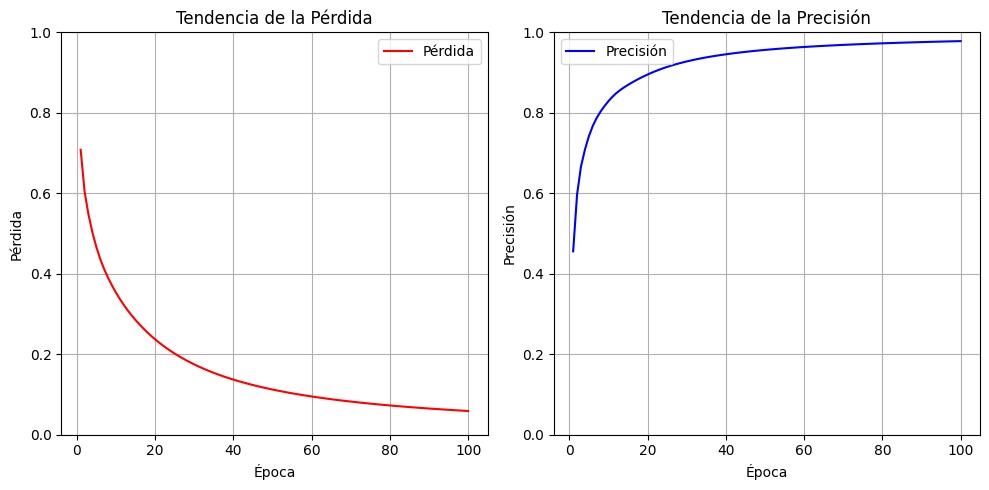

Época 100/100 - Pérdida: 0.0590  -  Precisión (BinaryAccuracy): 0.9782
Visualizando gráficas de tendencia.

¡Entrenamiento completado!
Modelo guardado en: ./A1/models/OTA_drone_model_E1_T1.keras
Historial de entrenamiento guardado en: ./A1/logs/training_history_E1_T1.csv y ./A1/logs/training_history_E1_T1.json


In [ ]:
# --- 4. Entrenar el Modelo con Visualización (Versión optimizada y flexible) ---

# Variable de control para las gráficas por imagen
visualize_activation_plots = False # <-- ¡El interruptor! Cambia a False para un entrenamiento rápido.

# Configuración del entrenamiento
desired_epochs = 100
plot_update_interval = 100

# --- Rutas para guardar el modelo y el historial ---
# Dirección actualizada
output_dir = './A1'
os.makedirs(output_dir, exist_ok=True)

model_save_path = os.path.join(output_dir, 'models/OTA_drone_model_E1_T1.keras')
history_csv_path = os.path.join(output_dir, 'logs/training_history_E1_T1.csv')
history_json_path = os.path.join(output_dir, 'logs/training_history_E1_T1.json')
history_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

print(f"\nComenzando el entrenamiento del modelo ({desired_epochs} Épocas).")
if visualize_activation_plots:
    print("¡Advertencia! La visualización de activaciones por imagen está ACTIVADA. Esto ralentizará el entrenamiento.")
else:
    print("La visualización de activaciones por imagen está DESACTIVADA para un entrenamiento más rápido.")

# Preparar el lote completo
X_batch_full = X_train
y_batch_full = y_train
num_samples = X_batch_full.shape[0]

for epoch in range(1, desired_epochs + 1):

    # --- PASO CLAVE: Barajar el dataset al inicio de cada época ---
    # Generar un índice aleatorio para barajar
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Aplicar el orden aleatorio a los datos de entrenamiento
    X_shuffled = X_batch_full[indices]
    y_shuffled = y_batch_full[indices]

    if visualize_activation_plots:
        print(f"\n--- Época {epoch}/{desired_epochs} ---")
        # Itera sobre cada imagen en el lote para la visualización detallada
        for i in range(X_shuffled.shape[0]):

            # Limpia la salida antes de imprimir la nueva gráfica
            clear_output(wait=True)

            X_sample = X_shuffled[i:i+1]
            y_sample = y_shuffled[i:i+1]

            # Realiza un paso de entrenamiento con una sola imagen (INEFICIENTE, solo para visualización)
            metrics = autoencoder_drone.train_on_batch(X_sample, y_sample)
            loss, accuracy = metrics[0], metrics[1]

            # Obtener la predicción para la muestra actual
            prediction_raw = autoencoder_drone.predict(X_sample, verbose=0)[0]

            # Lógica para graficar las activaciones
            true_offset_x_idx = np.argmax(y_sample[0, :11])
            true_offset_y_idx = np.argmax(y_sample[0, 11:])
            true_dx = map_index_to_offset(true_offset_x_idx, min_offset)
            true_dy = map_index_to_offset(true_offset_y_idx, min_offset)
            pred_offset_x_idx = np.argmax(prediction_raw[:11])
            pred_offset_y_idx = np.argmax(prediction_raw[11:])
            pred_dx = map_index_to_offset(pred_offset_x_idx, min_offset)
            pred_dy = map_index_to_offset(pred_offset_y_idx, min_offset)
            offset_labels = list(range(min_offset, max_offset + 1))

            # Código para generar las gráficas
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[1].bar(offset_labels, prediction_raw[:11], color='skyblue', label='Predicha X')
            true_x_activations = y_sample[0, :11]
            true_x_indices = np.where(true_x_activations == 1)[0]
            if len(true_x_indices) > 0:
                axes[1].stem([offset_labels[i] for i in true_x_indices], [1.0] * len(true_x_indices), linefmt='red', markerfmt='ro', basefmt=' ', label='Target X')
            axes[1].set_title(f'Activaciones Neuronas X (Época {epoch}, Imagen {i+1})')
            axes[1].set_xlabel('Offset X'); axes[0].set_ylabel('Probabilidad')
            axes[1].set_ylim(-0.05, 1.05); axes[0].set_xticks(offset_labels); axes[0].legend(); axes[0].grid(True)
            axes[0].bar(offset_labels, prediction_raw[11:], color='lightgreen', label='Predicha Y')
            true_y_activations = y_sample[0, 11:]
            true_y_indices = np.where(true_y_activations == 1)[0]
            if len(true_y_indices) > 0:
                axes[0].stem([offset_labels[i] for i in true_y_indices], [1.0] * len(true_y_indices), linefmt='purple', markerfmt='o', basefmt=' ', label='Target Y')
            axes[0].set_title(f'Activaciones Neuronas Y (Época {epoch}, Imagen {i+1})')
            axes[0].set_xlabel('Offset Y'); axes[1].set_ylabel('Probabilidad')
            axes[0].set_ylim(-0.05, 1.05); axes[1].set_xticks(offset_labels); axes[1].legend(); axes[1].grid(True)
            plt.tight_layout(); display(fig); plt.close(fig)

            print(f"Época {epoch}, Imagen {i+1} - Pérdida: {loss:.4f} -  Precisión: {accuracy:.4f}")
            print(f"Offset real: ({true_dx}, {true_dy}) - Predicción: ({pred_dx}, {pred_dy})")
            time.sleep(0.1)

        # Almacena las métricas de la última imagen del lote (para el historial)
        history_df.loc[epoch] = [epoch, loss, accuracy]

    else: # Modo de entrenamiento rápido
        # Realizar un paso de entrenamiento con el lote completo barajado
        metrics = autoencoder_drone.train_on_batch(X_shuffled, y_shuffled)
        loss, accuracy = metrics[0], metrics[1]
        history_df.loc[epoch] = [epoch, loss, accuracy]

    # Lógica de visualización de tendencia y guardado
    if not visualize_activation_plots and (epoch % plot_update_interval == 0 or epoch == desired_epochs):
        clear_output(wait=True)
        test_sample_index = random.randint(0, num_samples - 1)
        X_test_sample = X_train[test_sample_index:test_sample_index+1]
        y_test_sample = y_train[test_sample_index:test_sample_index+1]

        prediction_raw = autoencoder_drone.predict(X_test_sample, verbose=0)[0]
        true_offset_x_idx = np.argmax(y_test_sample[0, :11])
        true_offset_y_idx = np.argmax(y_test_sample[0, 11:])
        pred_offset_x_idx = np.argmax(prediction_raw[:11])
        pred_offset_y_idx = np.argmax(prediction_raw[11:])

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].plot(history_df['epoch'], history_df['loss'], label='Pérdida', color='red'); axes[0].set_title('Tendencia de la Pérdida'); axes[0].set_xlabel('Época'); axes[0].set_ylabel('Pérdida'); axes[0].set_ylim(0, 1); axes[0].grid(True); axes[0].legend()
        axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Precisión', color='blue'); axes[1].set_title('Tendencia de la Precisión'); axes[1].set_xlabel('Época'); axes[1].set_ylabel('Precisión'); axes[1].set_ylim(0, 1); axes[1].grid(True); axes[1].legend()
        plt.tight_layout(); display(fig); plt.close(fig)

        print(f"Época {epoch}/{desired_epochs} - Pérdida: {loss:.4f}  -  Precisión (BinaryAccuracy): {accuracy:.4f}")
        print("Visualizando gráficas de tendencia.")

# Finalizar el entrenamiento
print("\n¡Entrenamiento completado!")
autoencoder_drone.save(model_save_path)
history_df.to_csv(history_csv_path, index=False)
# Convert numpy floats to python floats before saving to json
history_df.astype(float).to_json(history_json_path, orient='records', lines=True)
print(f"Modelo guardado en: {model_save_path}")
print(f"Historial de entrenamiento guardado en: {history_csv_path} y {history_json_path}")

## Second Training OTA

### Settings

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, Model, saving
import keras
import cv2
import numpy as np
import random
import os
from IPython.display import display, Image, clear_output # Para Colab/Jupyter
import time
import matplotlib.pyplot as plt # Importar matplotlib para graficar
import pandas as pd # Para guardar el historial en CSV
import json # Para guardar el historial en JSON
import tensorflow.keras.backend as K # Importar Keras backend para la métrica personalizada
import math

# Montar Google Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Drive: {e}. Intente recargar la página.")

# Definir la ruta de la carpeta del proyecto DENTRO de Drive
# **ASEGÚRATE DE QUE ESTA RUTA COINCIDA CON LA UBICACIÓN DE TU CARPETA**
RUTA_PROYECTO_DRIVE = '/content/drive/MyDrive/Implementacion_Tesis_Drones'

# Cambiar el directorio de trabajo al proyecto
if os.path.isdir(RUTA_PROYECTO_DRIVE):
    %cd {RUTA_PROYECTO_DRIVE}
    print(f"Directorio de trabajo cambiado a: {os.getcwd()}")
else:
    print(f"Error: La carpeta '{RUTA_PROYECTO_DRIVE}' no fue encontrada.")
    print("Asegúrese de que la carpeta compartida esté en la raíz de su Drive.")
# =========================================================

# --- Rutas para cargar/guardar el modelo y el historial deprecated(?)---
output_dir = './A1/'
# Asegúrate de que la carpeta exista
os.makedirs(output_dir, exist_ok=True)
# Ruta del modelo previamente guardado (formato .keras)
model_load_path = os.path.join(output_dir, 'models/OTA_drone_model_E1_T1.keras')
# Rutas para guardar el historial de esta nueva fase de entrenamiento
history_csv_path_rotated = os.path.join(output_dir, 'logs/training_history_E2_T1.csv')
history_json_path_rotated = os.path.join(output_dir, 'logs/training_history_E2_T1.json')
# Ruta para guardar el modelo después de esta fase de entrenamiento (opcional, puedes sobrescribir el anterior o guardar una nueva versión)
model_save_path_rotated = os.path.join(output_dir, 'models/OTA_drone_model_E2_T1.keras')

# Ruta de la imagen única a utilizar para el entrenamiento
image_path = './images/dron/0029(1).jpg'


2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
/content/drive/MyDrive/Implementacion_Tesis_Drones
Directorio de trabajo cambiado a: /content/drive/MyDrive/Implementacion_Tesis_Drones


### 1. Definición del Autoencoder de Seguimiento de Offset

In [ ]:
# --- 1. Definición del Autoencoder de Seguimiento de Offset (Debe coincidir con el modelo guardado) ---

# Dimensiones del ROI
roi_height = 160
roi_width = 240
input_vector_size = roi_height * roi_width

# Dimensiones de la capa oculta (espacio latente)
latent_dimensions = 51

# Dimensiones de la capa de salida (para el offset tracking)
output_dimensions = 22 # 11 para X y 11 para Y

# Registra la clase para poder cargarla correctamente con tf.keras.models.load_model
@keras.saving.register_keras_serializable(package="MyModels")
class OffsetTrackingAutoencoder(Model):
  def __init__(self, latent_dim, output_dim, input_shape, **kwargs):
    super(OffsetTrackingAutoencoder, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.input_shape_ = input_shape

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      layers.Flatten(),
      layers.Dense(self.latent_dim, activation='relu')
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(self.output_dim, activation='sigmoid')
    ])

  def build(self, input_shape):
      # Definimos el input_shape_ aqui para que el get_config pueda usarlo
      self.input_shape_ = input_shape
      self.encoder.build(input_shape)
      input_shape = self.encoder.compute_output_shape(input_shape)
      self.decoder.build(input_shape)
      super().build(input_shape)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  # Este método es necesario para la serialización de la configuración
  def get_config(self):
    config = super(OffsetTrackingAutoencoder, self).get_config()
    config.update({
        'latent_dim': self.latent_dim,
        'output_dim': self.output_dim,
        # self.input_shape_ se inicializa en el método build
        'input_shape': self.input_shape_[1:]
    })
    return config

  @classmethod
  def from_config(cls, config):
      # Remueve 'input_shape' del config para evitar un error de kwargs en el constructor
      input_shape = config.pop('input_shape', None)
      return cls(input_shape=input_shape, **config)


### 2. Cargar el Modelo Previamente Entrenado

In [ ]:
# --- 2. Cargar el Modelo Previamente Entrenado ---
print("\nCargando el modelo previamente entrenado...")
try:
    # Verificamos si el archivo existe antes de intentar cargarlo
    if not os.path.exists(model_load_path):
        raise FileNotFoundError(f"Archivo no encontrado: {model_load_path}")

    # Necesitas pasar custom_objects para que Keras sepa cómo cargar tu clase y métrica
    autoencoder_drone = tf.keras.models.load_model(
        model_load_path,
        custom_objects={
            'OffsetTrackingAutoencoder': OffsetTrackingAutoencoder # Agregar la clase personalizada
        }
    )
    print(f"Modelo cargado exitosamente desde: {model_load_path}")
    print("Resumen del modelo cargado:")
    autoencoder_drone.summary()
except FileNotFoundError as e:
    print(f"Error al cargar el modelo: {e}")
    print("Por favor, verifica la ruta y el nombre del archivo en tu Google Drive.")
    print("Si el archivo no existe, se creará un nuevo modelo para continuar.")
    # Crea una instancia nueva si el archivo no se encuentra
    autoencoder_drone = OffsetTrackingAutoencoder(
        latent_dim=latent_dimensions,
        output_dim=output_dimensions,
        input_shape=(roi_height, roi_width, 1)
    )
    autoencoder_drone.build(input_shape=(None, roi_height, roi_width, 1))
    autoencoder_drone.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])
except Exception as e:
    print(f"Ocurrió un error inesperado al cargar el modelo: {e}")
    print("Se creará un nuevo modelo para continuar.")
    # Crea una instancia nueva si ocurre otro tipo de error
    autoencoder_drone = OffsetTrackingAutoencoder(
        latent_dim=latent_dimensions,
        output_dim=output_dimensions,
        input_shape=(roi_height, roi_width, 1)
    )
    autoencoder_drone.build(input_shape=(None, roi_height, roi_width, 1))
    autoencoder_drone.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])


Cargando el modelo previamente entrenado...
Modelo cargado exitosamente desde: ./A1/models/OTA_drone_model_E1_T1.keras
Resumen del modelo cargado:


Model: "offset_tracking_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 51)             │     1,958,451 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 22)             │         1,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,878,787 (22.43 MB)

 Trainable params: 1,959,595 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,919,192 (14.95 MB)

### 1. Definición de Parámetros y Ruta

In [ ]:
# --- 1. Definición de Parámetros y Rutas ---

# Dimensiones de tu ROI
roi_height = 160
roi_width = 240
output_image_size = (roi_width, roi_height) # Tamaño de tu imagen redimensionada (imagen completa)

# Centro 'verdadero' del dron en la imagen redimensionada
drone_true_center_x = 120
drone_true_center_y = 80

# Parámetros para Canny Edge Detection
low_threshold = 50
high_threshold = 150

# Rango de offsets para dx y dy.
min_offset = -5
max_offset = 5
offset_range = range(min_offset, max_offset + 1)
num_offsets = len(offset_range) # 11x11 = 121 combinaciones

# Rango de rotación del dron
min_rotation_angle = -25
max_rotation_angle = 25
rotation_angles = list(range(min_rotation_angle, max_rotation_angle+1)) # De -30 a 30, 51 ángulos en total
num_rotations = len(rotation_angles) # 51 ángulos

output_dimensions = num_offsets * 2 # 11 para X y 11 para Y -> 22

# --- 2. Cargar y Preprocesar la Imagen Base ---

try:
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen de {image_path}. Creando una imagen de ejemplo.")

    img_resize = cv2.resize(original_img, output_image_size)

except FileNotFoundError:
    print("Creando una imagen de ejemplo (blanca) para la demostración y entrenamiento.")
    img_resize = np.ones((output_image_size[1], output_image_size[0], 3), dtype=np.uint8) * 255
except Exception as e:
    print(f"Error al cargar/procesar la imagen, creando una de ejemplo: {e}")
    img_resize = np.ones((output_image_size[1], output_image_size[0], 3), dtype=np.uint8) * 255

print("\nImagen base cargada y redimensionada.")
#print(rotation_angles)



Imagen base cargada y redimensionada.


### 2. Generar el Dataset con Rotaciones y Offsets

In [ ]:
# --- 3. Aplicar Canny a la imagen base ANTES de rotar ---
# Convertir a escala de grises
img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
# Aplicar Canny
edges_base = cv2.Canny(img_gray, low_threshold, high_threshold)
dataset_size = num_offsets*num_offsets*num_rotations

print("\nDetección de bordes Canny aplicada a la imagen base. Esto evita el borde blanco en la rotación.")


# --- 4. Generar el Dataset con Rotaciones y Offsets ---

X_train_list = [] # Para las imágenes ROI con bordes Canny
y_train_list = [] # Para las etiquetas de offset (vector de 22)

# Función para mapear un offset (ej. -5 a 5) a un índice (0 a 10)
def map_offset_to_index(offset_value, min_val):
    return offset_value - min_val

def map_index_to_offset(index_value, min_val):
    return index_value + min_val

print(f"\nComenzando la generación del dataset con {dataset_size} imágenes...")
progress_counter = 0

# Bucle principal para generar el dataset
for dx in offset_range:
    for dy in offset_range:
        # Para cada combinación de offset, rotamos la imagen
        for angle in rotation_angles:
            # Rotar la imagen de BORDES
            (h, w) = edges_base.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            edges_rotated = cv2.warpAffine(edges_base, M, (w, h))

            # Calcular el centro del ROI para esta instancia
            roi_center_x = drone_true_center_x - dx
            roi_center_y = drone_true_center_y - dy

            # Calcular las coordenadas de la esquina superior izquierda y derecha del ROI.
            x1_roi = int(roi_center_x - roi_width / 2)
            y1_roi = int(roi_center_y - roi_height / 2)
            x2_roi = int(roi_center_x + roi_width / 2)
            y2_roi = int(roi_center_y + roi_height / 2)

            # Asegurar que el ROI esté dentro de los límites de la imagen
            x1_bounded = max(0, x1_roi)
            y1_bounded = max(0, y1_roi)
            x2_bounded = min(edges_rotated.shape[1], x2_roi)
            y2_bounded = min(edges_rotated.shape[0], y2_roi)

            # Extraer el ROI de la imagen de BORDES ROTADA
            ROI_final = edges_rotated[y1_bounded:y2_bounded, x1_bounded:x2_bounded]

            # Asegurarse de que el ROI tenga el tamaño exacto deseado (esto ya no debería ser necesario, pero es una buena práctica)
            if ROI_final.shape[0] != roi_height or ROI_final.shape[1] != roi_width:
                ROI_final = cv2.resize(ROI_final, (roi_width, roi_height))

            # Normalizar los píxeles a un rango de 0 a 1
            edges_normalized = ROI_final.astype('float32') / 255.0
            edges_input = np.expand_dims(edges_normalized, axis=-1)

            X_train_list.append(edges_input)

            # Crear la etiqueta y_train (vector de 22)
            offset_index_x = map_offset_to_index(dx, min_offset)
            offset_index_y = map_offset_to_index(dy, min_offset)
            label_vector = np.zeros(output_dimensions, dtype='float32')
            label_vector[offset_index_x] = 1.0
            label_vector[11 + offset_index_y] = 1.0

            # Crear el vector one-hot de 22 elementos
            label_vector = np.zeros(output_dimensions, dtype='float32')
            label_vector[offset_index_x] = 1.0        # Activa la neurona para el offset X
            label_vector[11 + offset_index_y] = 1.0   # Activa la neurona para el offset Y


            y_train_list.append(label_vector)

            progress_counter += 1
            if progress_counter % 1000 == 0:
                print(f"Progreso: {progress_counter}/{num_offsets*num_offsets*num_rotations} imágenes generadas.")

# Convertir las listas a arrays de NumPy al final
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# Número de muestras generadas
num_samples = len(X_train_list)

print(f"\nDataset generado.")
print(f"Número total de muestras: {len(X_train_list)}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")


Detección de bordes Canny aplicada a la imagen base. Esto evita el borde blanco en la rotación.

Comenzando la generación del dataset con 6171 imágenes...
Progreso: 1000/6171 imágenes generadas.
Progreso: 2000/6171 imágenes generadas.
Progreso: 3000/6171 imágenes generadas.
Progreso: 4000/6171 imágenes generadas.
Progreso: 5000/6171 imágenes generadas.
Progreso: 6000/6171 imágenes generadas.

Dataset generado.
Número total de muestras: 6171
Forma de X_train: (6171, 160, 240, 1)
Forma de y_train: (6171, 22)


### Visualizar Imágenes Aleatorias para Verificación





Mostrando 5 imágenes aleatorias del dataset generado para verificar la rotación...


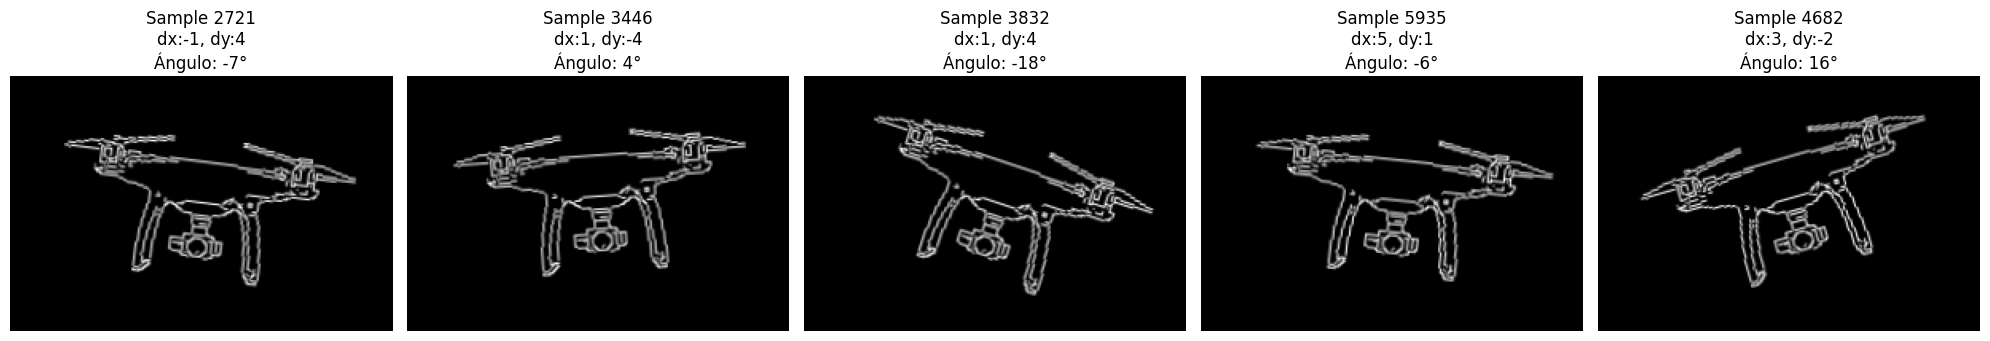


Verificación de imágenes completada. Ahora puedes usar este dataset para el entrenamiento.


In [ ]:
# --- 5. Visualizar Imágenes Aleatorias para Verificación ---

print("\nMostrando 5 imágenes aleatorias del dataset generado para verificar la rotación...")
num_to_display = 5
fig, axes = plt.subplots(1, num_to_display, figsize=(20, 4))

for i in range(num_to_display):
    # Seleccionar un índice aleatorio
    random_index = random.randint(0, len(X_train) - 1)

    # Obtener la imagen y la etiqueta
    random_image = X_train[random_index]
    random_label = y_train[random_index]

    # Convertir el vector one-hot a valores de offset
    dx_idx = np.argmax(random_label[:11])
    dy_idx = np.argmax(random_label[11:])
    dx = dx_idx + min_offset
    dy = dy_idx + min_offset

    # Calcular el ángulo de rotación a partir del índice
    angle_index = random_index % num_rotations
    angle = rotation_angles[angle_index]

    # Quitar la dimensión del canal para mostrar la imagen correctamente
    image_display = random_image.squeeze()

    axes[i].imshow(image_display, cmap='gray')
    axes[i].set_title(f'Sample {random_index}\ndx:{dx}, dy:{dy}\nÁngulo: {angle}°')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\nVerificación de imágenes completada. Ahora puedes usar este dataset para el entrenamiento.")


### 5. Entrenar el Modelo con Visualización y Guardado

Época 100/100 - Pérdida Promedio: 0.0230 - Precisión Promedio: 0.9941
Visualizando gráficas de tendencia.


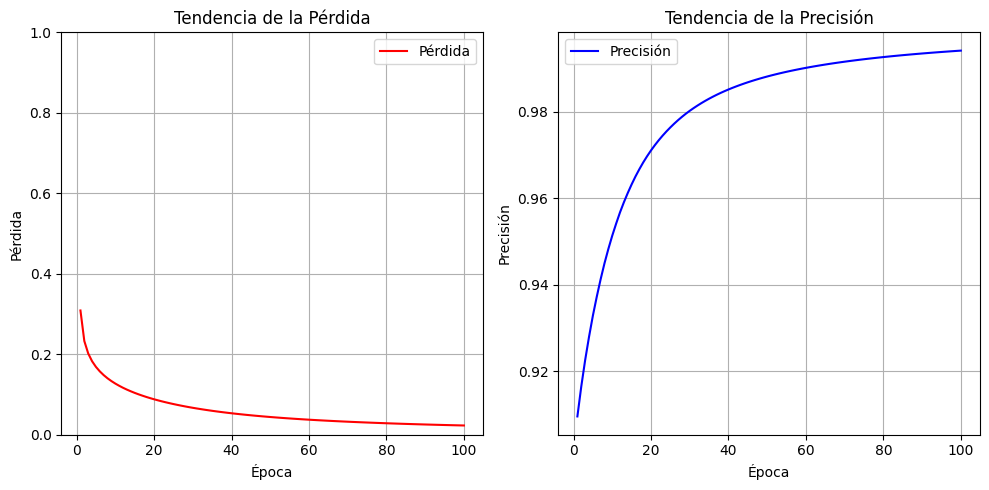


¡Entrenamiento completado!
Modelo guardado en: ./A1/models/OTA_drone_model_E2_T2.keras
Historial de entrenamiento guardado en: ./A1/logs/training_history_E2_T1.csv y ./A1/logs/training_history_E2_T1.json
Pérdida final en el conjunto de entrenamiento (rotado): 0.0006
Precisión final en el conjunto de entrenamiento (rotado): 1.0000


Model: "offset_tracking_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 51)             │     1,958,451 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 22)             │         1,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,878,787 (22.43 MB)

 Trainable params: 1,959,595 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,919,192 (14.95 MB)

In [ ]:
# --- 5. Entrenar el Modelo con Visualización y Guardado (Versión para datasets grandes) ---

# Variable de control para las gráficas por lote
visualize_activation_plots = False # <-- ¡El interruptor! Cambia a False para un entrenamiento rápido.

# Configuración del entrenamiento
desired_epochs = 100
batch_size = 121 # Tamaño de mini-lote, que es un divisor de 6171.
plot_update_interval = 10 # Actualizar la gráfica cada N épocas

history_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

print(f"\nComenzando el re-entrenamiento del modelo ({desired_epochs} Épocas) con imágenes ROTADAS.")
print(f"Usando un tamaño de lote de: {batch_size}")
if visualize_activation_plots:
    print("¡Advertencia! La visualización de activaciones por lote está ACTIVADA. Esto ralentizará el entrenamiento.")
else:
    print("La visualización de activaciones por lote está DESACTIVADA para un entrenamiento más rápido.")

# Preparar el dataset completo
X_batch_full = X_train
y_batch_full = y_train
num_samples = X_batch_full.shape[0]
num_batches_per_epoch = math.ceil(num_samples / batch_size)

for epoch in range(1, desired_epochs + 1):
    # Barajar el dataset al inicio de cada época
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    X_shuffled = X_batch_full[indices]
    y_shuffled = y_batch_full[indices]

    # Variables para promediar las métricas de todos los lotes en la época
    epoch_loss_avg = 0
    epoch_accuracy_avg = 0

    if visualize_activation_plots:
        print(f"\n--- Época {epoch}/{desired_epochs} ---")

    # Iterar sobre los mini-lotes
    for i in range(num_batches_per_epoch):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, num_samples)

        X_batch = X_shuffled[start_index:end_index]
        y_batch = y_shuffled[start_index:end_index]

        # Realizar un paso de entrenamiento con el mini-lote
        metrics = autoencoder_drone.train_on_batch(X_batch, y_batch)
        loss, accuracy = metrics[0], metrics[1]

        # Acumular las métricas para promediar al final de la época
        epoch_loss_avg += loss
        epoch_accuracy_avg += accuracy


        if visualize_activation_plots:
            clear_output(wait=True)
            print(f"Época {epoch}/{desired_epochs} - Lote {i+1}/{num_batches_per_epoch}")

            # Obtener una muestra aleatoria del lote actual para la visualización
            test_sample_in_batch_idx = random.randint(0, X_batch.shape[0] - 1)
            X_test_sample = X_batch[test_sample_in_batch_idx:test_sample_in_batch_idx+1]
            y_test_sample = y_batch[test_sample_in_batch_idx:test_sample_in_batch_idx+1]

            # Obtener la predicción para la muestra actual
            prediction_raw = autoencoder_drone.predict(X_test_sample, verbose=0)[0]

            # Lógica para graficar las activaciones
            true_offset_x_idx = np.argmax(y_test_sample[0, :11])
            true_offset_y_idx = np.argmax(y_test_sample[0, 11:])
            true_dx = map_index_to_offset(true_offset_x_idx, min_offset)
            true_dy = map_index_to_offset(true_offset_y_idx, min_offset)
            pred_offset_x_idx = np.argmax(prediction_raw[:11])
            pred_offset_y_idx = np.argmax(prediction_raw[11:])
            pred_dx = map_index_to_offset(pred_offset_x_idx, min_offset)
            pred_dy = map_index_to_offset(pred_offset_y_idx, min_offset)
            offset_labels = list(range(min_offset, max_offset + 1))

            # Código para generar las gráficas
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].bar(offset_labels, prediction_raw[:11], color='skyblue', label='Predicha X')
            true_x_activations = y_test_sample[0, :11]
            true_x_indices = np.where(true_x_activations == 1)[0]
            if len(true_x_indices) > 0:
                axes[0].stem([offset_labels[i] for i in true_x_indices], [1.0] * len(true_x_indices), linefmt='red', markerfmt='ro', basefmt=' ', label='Target X')
            axes[0].set_title(f'Activaciones Neuronas X (Lote {i+1})')
            axes[0].set_xlabel('Offset X'); axes[0].set_ylabel('Probabilidad')
            axes[0].set_ylim(-0.05, 1.05); axes[0].set_xticks(offset_labels); axes[0].legend(); axes[0].grid(True)
            axes[1].bar(offset_labels, prediction_raw[11:], color='lightgreen', label='Predicha Y')
            true_y_activations = y_test_sample[0, 11:]
            true_y_indices = np.where(true_y_activations == 1)[0]
            if len(true_y_indices) > 0:
                axes[1].stem([offset_labels[i] for i in true_y_indices], [1.0] * len(true_y_indices), linefmt='purple', markerfmt='o', basefmt=' ', label='Target Y')
            axes[1].set_title(f'Activaciones Neuronas Y (Lote {i+1})')
            axes[1].set_xlabel('Offset Y'); axes[1].set_ylabel('Probabilidad')
            axes[1].set_ylim(-0.05, 1.05); axes[1].set_xticks(offset_labels); axes[1].legend(); axes[1].grid(True)
            plt.tight_layout(); display(fig); plt.close(fig)

            print(f"Pérdida del lote: {loss:.4f} - Precisión: {accuracyc:.4f}")
            print(f"Offset real: ({true_dx}, {true_dy}) - Predicción: ({pred_dx}, {pred_dy})")
            time.sleep(0.15)

    # Calcular el promedio de las métricas para la época actual
    avg_loss = epoch_loss_avg / num_batches_per_epoch
    avg_accuracy = epoch_accuracy_avg / num_batches_per_epoch

    # Almacenar las métricas promediadas en el historial
    history_df.loc[epoch] = [epoch, avg_loss, avg_accuracy]

    # Lógica de visualización de tendencia y guardado
    if epoch % plot_update_interval == 0 or epoch == desired_epochs:
        if not visualize_activation_plots:
            clear_output(wait=True)
            print(f"Época {epoch}/{desired_epochs} - Pérdida Promedio: {avg_loss:.4f} - Precisión Promedio: {avg_accuracy:.4f}")
            print("Visualizando gráficas de tendencia.")

        # Muestra las gráficas de tendencia
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].plot(history_df['epoch'], history_df['loss'], label='Pérdida', color='red'); axes[0].set_title('Tendencia de la Pérdida'); axes[0].set_xlabel('Época'); axes[0].set_ylabel('Pérdida'); axes[0].set_ylim(0, 1); axes[0].grid(True); axes[0].legend()
        axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Precisión', color='blue'); axes[1].set_title('Tendencia de la Precisión'); axes[1].set_xlabel('Época'); axes[1].set_ylabel('Precisión'); axes[1].grid(True); axes[1].legend()

        plt.tight_layout(); display(fig); plt.close(fig)

        time.sleep(0.1)

# Finalizar el entrenamiento
print("\n¡Entrenamiento completado!")
autoencoder_drone.save(model_save_path_rotated)
history_df.to_csv(history_csv_path_rotated, index=False)
history_df.to_json(history_json_path_rotated, orient='records', lines=True)
print(f"Modelo guardado en: {model_save_path_rotated}")
print(f"Historial de entrenamiento guardado en: {history_csv_path_rotated} y {history_json_path_rotated}")

# Evaluación final del modelo
loss_final, accuracy_final, = autoencoder_drone.evaluate(X_train, y_train, verbose=0)
print(f"Pérdida final en el conjunto de entrenamiento (rotado): {loss_final:.4f}")
print(f"Precisión final en el conjunto de entrenamiento (rotado): {accuracy_final:.4f}")

autoencoder_drone.summary()


## Third Training OTA

### Setting

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model, saving
import cv2
import numpy as np
import random
import os
from IPython.display import display, Image, clear_output
import time
import matplotlib.pyplot as plt
import pandas as pd
import json
import tensorflow.keras.backend as K
import math
import glob

# --- 0. Verificar la disponibilidad de la GPU ---

def gpus_available():
    """Devuelve True si hay al menos un dispositivo GPU disponible."""
    gpus = tf.config.list_physical_devices('GPU')
    return len(gpus) > 0

# Uso típico
if gpus_available():
    print("GPU disponible:", tf.config.list_physical_devices('GPU'), "Usando GPU para el entrenamiento.")
else:
     print("No se detectó una GPU. El entrenamiento se ejecutará en la CPU, lo cual será más lento.")

# Montar Google Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Drive: {e}. Intente recargar la página.")

# Definir la ruta de la carpeta del proyecto DENTRO de Drive
# **ASEGÚRATE DE QUE ESTA RUTA COINCIDA CON LA UBICACIÓN DE TU CARPETA**
RUTA_PROYECTO_DRIVE = '/content/drive/MyDrive/Implementacion_Tesis_Drones'

# Cambiar el directorio de trabajo al proyecto
if os.path.isdir(RUTA_PROYECTO_DRIVE):
    %cd {RUTA_PROYECTO_DRIVE}
    print(f"Directorio de trabajo cambiado a: {os.getcwd()}")
else:
    print(f"Error: La carpeta '{RUTA_PROYECTO_DRIVE}' no fue encontrada.")
    print("Asegúrese de que la carpeta compartida esté en la raíz de su Drive.")

# --- Rutas para cargar/guardar el modelo, el historial y el dataset ---
output_dir = './A1'
os.makedirs(output_dir, exist_ok=True)

# Rutas del modelo y historial para el nuevo dataset escalado y rotado
model_load_path = os.path.join(output_dir, 'models/OTA_drone_model_E3_T2.keras')
history_csv_path_rotated = os.path.join(output_dir, 'logs/training_history_E3_T3.csv')
history_json_path_rotated = os.path.join(output_dir, 'logs/training_history_E3_T3.json')
model_save_path_rotated = os.path.join(output_dir, 'models/OTA_drone_model_E3_T3.keras')

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] Usando GPU para el entrenamiento.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado exitosamente.
/content/drive/MyDrive/Implementacion_Tesis_Drones
Directorio de trabajo cambiado a: /content/drive/MyDrive/Implementacion_Tesis_Drones


### Definición del Autoencoder de Seguimiento de Offset

In [ ]:
## --- 1. Definición del Autoencoder de Seguimiento de Offset (Debe coincidir con el modelo guardado) ---

# Dimensiones del ROI
roi_height = 160
roi_width = 240
input_vector_size = roi_height * roi_width

# Dimensiones de la capa oculta (espacio latente)
latent_dimensions = 51

# Dimensiones de la capa de salida (para el offset tracking)
output_dimensions = 22 # 11 para X y 11 para Y

# Registra la clase para poder cargarla correctamente con tf.keras.models.load_model
@keras.saving.register_keras_serializable(package="MyModels")
class OffsetTrackingAutoencoder(Model):
  def __init__(self, latent_dim, output_dim, input_shape, **kwargs):
    super(OffsetTrackingAutoencoder, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.input_shape_ = input_shape

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      layers.Flatten(),
      layers.Dense(self.latent_dim, activation='relu')
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(self.output_dim, activation='sigmoid')
    ])

  def build(self, input_shape):
      # Definimos el input_shape_ aqui para que el get_config pueda usarlos
      self.input_shape_ = input_shape
      self.encoder.build(input_shape)
      input_shape = self.encoder.compute_output_shape(input_shape)
      self.decoder.build(input_shape)
      super().build(input_shape)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  # Este método es necesario para la serialización de la configuración
  def get_config(self):
    config = super(OffsetTrackingAutoencoder, self).get_config()
    config.update({
        'latent_dim': self.latent_dim,
        'output_dim': self.output_dim,
        # self.input_shape_ se inicializa en el método build
        'input_shape': self.input_shape_[1:]
    })
    return config

  @classmethod
  def from_config(cls, config):
      # Remueve 'input_shape' del config para evitar un error de kwargs en el constructor
      input_shape = config.pop('input_shape', None)
      return cls(input_shape=input_shape, **config)

### 2. Cargar el Modelo Previamente Entrenado

In [ ]:
# --- 2. Cargar el Modelo Previamente Entrenado ---
print("\nCargando el modelo previamente entrenado...")
try:
    if not os.path.exists(model_load_path):
        raise FileNotFoundError(f"Archivo no encontrado: {model_load_path}")

    autoencoder_drone = tf.keras.models.load_model(
        model_load_path,
        custom_objects={
            'OffsetTrackingAutoencoder': OffsetTrackingAutoencoder
        }
    )
    print(f"Modelo cargado exitosamente desde: {model_load_path}")
    print("Resumen del modelo cargado:")
    autoencoder_drone.summary()
except FileNotFoundError as e:
    print(f"Error al cargar el modelo: {e}")
    print("Si el archivo no existe, se creará un nuevo modelo para continuar.")
    autoencoder_drone = OffsetTrackingAutoencoder(
        latent_dim=latent_dimensions,
        output_dim=output_dimensions,
        input_shape=(roi_height, roi_width, 1)
    )
    autoencoder_drone.build(input_shape=(None, roi_height, roi_width, 1))
    autoencoder_drone.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])
except Exception as e:
    print(f"Ocurrió un error inesperado al cargar el modelo: {e}")
    print("Se creará un nuevo modelo para continuar.")
    autoencoder_drone = OffsetTrackingAutoencoder(
        latent_dim=latent_dimensions,
        output_dim=output_dimensions,
        input_shape=(roi_height, roi_width, 1)
    )
    autoencoder_drone.build(input_shape=(None, roi_height, roi_width, 1))
    autoencoder_drone.compile(optimizer='adam', loss='binary_crossentropy', metrics=['BinaryAccuracy'])


Cargando el modelo previamente entrenado...
Modelo cargado exitosamente desde: ./A1/models/OTA_drone_model_E3_T2.keras
Resumen del modelo cargado:


Model: "offset_tracking_autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 51)             │     1,958,451 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 22)             │         1,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,878,787 (22.43 MB)

 Trainable params: 1,959,595 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,919,192 (14.95 MB)

### 3. Generación y guardado del Dataset por lotes

In [ ]:
# --- 3. Generación del Dataset sobre la marcha (on-the-fly) ---
# Parámetros de la imagen base
image_path = './images/dron/0029(1).jpg'
low_threshold = 50
high_threshold = 150
roi_height = 160
roi_width = 240
output_image_size = (roi_width, roi_height)
drone_true_center_x = 120
drone_true_center_y = 80

try:
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen de {image_path}.")

    img_resize = cv2.resize(original_img, output_image_size)
    img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    edges_base = cv2.Canny(img_gray, low_threshold, high_threshold)

except FileNotFoundError:
    print("Creando una imagen de ejemplo (blanca) para la demostración y entrenamiento.")
    img_resize = np.ones((output_image_size[1], output_image_size[0], 3), dtype=np.uint8) * 255
    edges_base = np.zeros((output_image_size[1], output_image_size[0]), dtype=np.uint8)
except Exception as e:
    print(f"Error al cargar/procesar la imagen, creando una de ejemplo: {e}")
    img_resize = np.ones((output_image_size[1], output_image_size[0], 3), dtype=np.uint8) * 255
    edges_base = np.zeros((output_image_size[1], output_image_size[0]), dtype=np.uint8)

print("\nImagen base cargada y preprocesada con Canny.")

# Rango de offsets (de -5 a 5, 11 valores)
min_offset = -5
max_offset = 5
offset_range = list(range(min_offset, max_offset + 1))
num_offsets = len(offset_range)

# Rango de rotaciones (de -25 a 25 en pasos de 1, 51 valores)
rotation_angles = list(np.arange(-25, 26, 1))
num_rotations = len(rotation_angles)

# Rango de reducción de escala (selecciona una de las opciones a continuación)
scale_factors = list(np.arange(1.0, 0.24, -0.01))

num_scales = len(scale_factors)
total_samples = num_offsets * num_offsets * num_rotations * num_scales
print(f"\nNúmero total de combinaciones de dataset a generar: {total_samples}")

# Combinaciones de parámetros para iterar
combinations = [(dx, dy, angle, scale) for dx in offset_range for dy in offset_range for angle in rotation_angles for scale in scale_factors]

# Mezcla aleatoria de las combinaciones para un dataset homogéneo
random.shuffle(combinations)

# Función para mapear un offset a un índice
def map_offset_to_index(offset_value, min_val):
    return offset_value - min_val

def map_index_to_offset(index_value, min_val):
    return index_value + min_val

# --- Generador de datos sobre la marcha ---
def data_generator():
    """Genera datos de entrenamiento 'on-the-fly' para un uso eficiente de la memoria."""
    # Barajamos las combinaciones en cada época para un mejor entrenamiento
    random.shuffle(combinations)
    for dx, dy, angle, scale in combinations:
        # Lógica de generación de la imagen
        M_translate = np.float32([[1, 0, -dx], [0, 1, -dy]])
        translated_img = cv2.warpAffine(edges_base, M_translate, (roi_width, roi_height), borderValue=0)
        (h, w) = translated_img.shape[:2]
        center = (w // 2, h // 2)
        M_rotate = cv2.getRotationMatrix2D(center, angle, 1.0)
        edges_rotated = cv2.warpAffine(translated_img, M_rotate, (w, h))
        new_content_size = (int(w * scale), int(h * scale))
        edges_scaled = cv2.resize(edges_rotated, new_content_size, interpolation=cv2.INTER_AREA)
        canvas = np.zeros((roi_height, roi_width), dtype=np.uint8)
        scaled_h, scaled_w = edges_scaled.shape[:2]
        start_x = (roi_width - scaled_w) // 2
        start_y = (roi_height - scaled_h) // 2
        end_x = start_x + scaled_w
        end_y = start_y + scaled_h
        canvas[start_y:end_y, start_x:end_x] = edges_scaled[:roi_height, :roi_width]
        final_image = canvas
        edges_normalized = final_image.astype('float32') / 255.0
        edges_input = np.expand_dims(edges_normalized, axis=-1)

        # Crear la etiqueta y_train (vector de 22)
        offset_index_x = map_offset_to_index(dx, min_offset)
        offset_index_y = map_offset_to_index(dy, min_offset)
        label_vector = np.zeros(output_dimensions, dtype='float32')
        label_vector[offset_index_x] = 1.0     # Activa la neurona para el offset X
        label_vector[11 + offset_index_y] = 1.0 # Activa la neurona para el offset Y

        yield edges_input, label_vector


Imagen base cargada y preprocesada con Canny.

Número total de combinaciones de dataset a generar: 468996


#### 3.1. Visualizar Imágenes Aleatorias para Verificación


Mostrando 5 imágenes aleatorias del dataset para verificación...


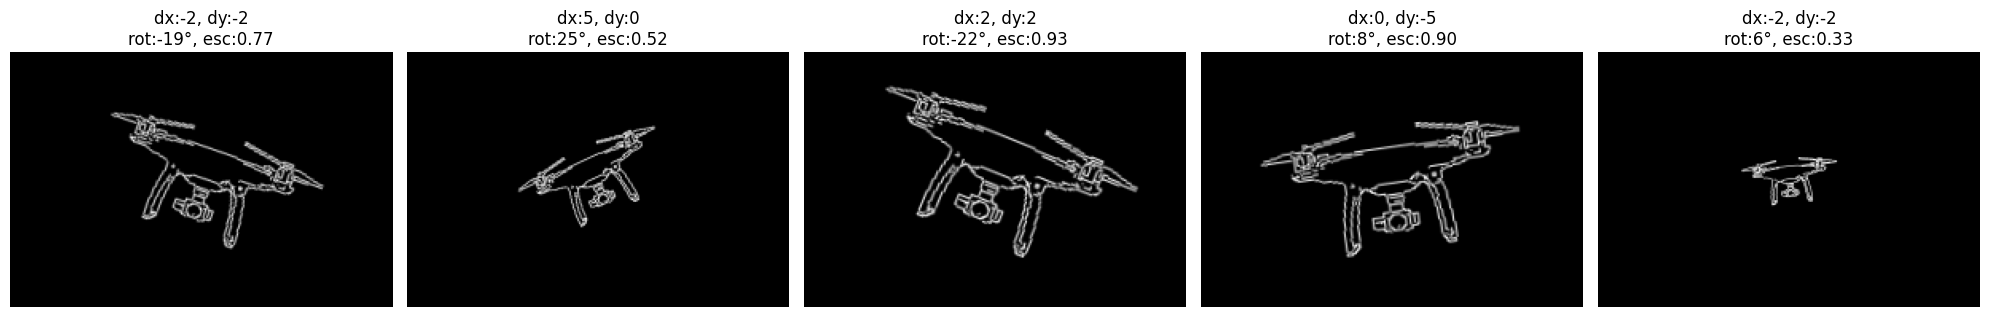


Verificación de imágenes completada.


In [ ]:
# --- 3.1. Visualizar Imágenes Aleatorias para Verificación ---
print("\nMostrando 5 imágenes aleatorias del dataset para verificación...")
num_to_display = 5
fig, axes = plt.subplots(1, num_to_display, figsize=(20, 4))

# Seleccionar 5 combinaciones aleatorias del total para la visualización
random_combinations = random.sample(combinations, num_to_display)

for i, (dx, dy, angle, scale) in enumerate(random_combinations):
    # Lógica de generación de la imagen (duplicada de la sección 4 para la visualización)
    M_translate = np.float32([[1, 0, -dx], [0, 1, -dy]])
    translated_img = cv2.warpAffine(edges_base, M_translate, (roi_width, roi_height), borderValue=0)
    (h, w) = translated_img.shape[:2]
    center = (w // 2, h // 2)
    M_rotate = cv2.getRotationMatrix2D(center, angle, 1.0)
    edges_rotated = cv2.warpAffine(translated_img, M_rotate, (w, h))
    new_content_size = (int(w * scale), int(h * scale))
    edges_scaled = cv2.resize(edges_rotated, new_content_size, interpolation=cv2.INTER_AREA)
    canvas = np.zeros((roi_height, roi_width), dtype=np.uint8)
    scaled_h, scaled_w = edges_scaled.shape[:2]
    start_x = (roi_width - scaled_w) // 2
    start_y = (roi_height - scaled_h) // 2
    end_x = start_x + scaled_w
    end_y = start_y + scaled_h
    canvas[start_y:end_y, start_x:end_x] = edges_scaled[:roi_height, :roi_width]
    final_image = canvas

    # Normalizar y agregar la dimensión de canal
    edges_normalized = final_image.astype('float32') / 255.0
    image_display = np.expand_dims(edges_normalized, axis=-1)

    # Decodificar el vector de etiqueta a offsets
    offset_index_x = map_offset_to_index(dx, min_offset)
    offset_index_y = map_offset_to_index(dy, min_offset)

    axes[i].imshow(image_display[:, :, 0], cmap='gray')
    axes[i].set_title(f'dx:{dx}, dy:{dy}\nrot:{angle}°, esc:{scale:.2f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\nVerificación de imágenes completada.")


### 4. Entrenar el Modelo con la generación de lotes en tiempo real


Lote 31 de la Época 1


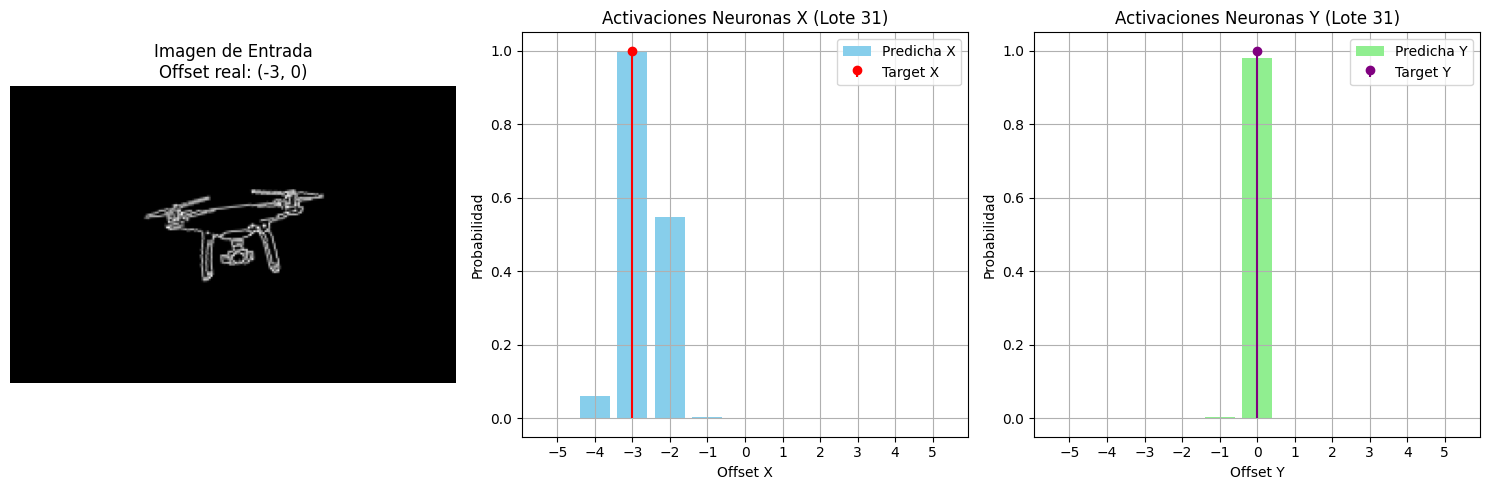

Pérdida del lote: 0.0510 - Precisión: 0.9770
Offset real: (-3, 0) - Predicción: (-3, 0)
Época 1/50 - Lote 41/3876

KeyboardInterrupt: 

In [ ]:
# --- 4. Entrenar el Modelo con la generación de lotes en tiempo real ---

# Variable de control para las gráficas por lote y la visualización de imágenes
visualize_activation_plots = True # Cambia a True para ver las activaciones del modelo
visualize_batch_images = True     # Cambia a True para ver las imágenes del lote
minimal_batch_size = 121

# Configuración del entrenamiento
desired_epochs = 50
batch_size = minimal_batch_size # Tamaño de mini-lote, ahora 121 x 10
plot_update_interval = 1 # Actualizar la gráfica cada N épocas
save_interval = 5 # Guardar el modelo cada 5 épocas

history_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

print(f"\nComenzando el re-entrenamiento del modelo ({desired_epochs} Épocas) con el nuevo dataset escalado y rotado.")
print(f"¡El tamaño del lote se ha aumentado a {batch_size} para un entrenamiento más eficiente!")
if visualize_activation_plots:
    print("¡Advertencia! La visualización de activaciones por lote está ACTIVADA. Esto ralentizará el entrenamiento.")
if visualize_batch_images:
    print("¡Advertencia! La visualización de imágenes por lote está ACTIVADA. Esto ralentizará el entrenamiento.")

num_batches_per_epoch = math.ceil(total_samples / batch_size)

# Crear un array de índices que se barajará al inicio de cada época
indices = np.arange(total_samples)

for epoch in range(1, desired_epochs + 1):
    # Barajar los índices al inicio de cada época para un orden aleatorio
    random.shuffle(indices)

    # Variables para promediar las métricas de todos los lotes en la época
    epoch_loss_avg = 0
    epoch_accuracy_avg = 0
    X_batch_last = None # Variable para guardar el último lote generado
    y_batch_last = None # Variable para guardar las etiquetas del último lote generado

    # Imprimir el inicio de cada época
    print(f"\n--- Época {epoch}/{desired_epochs} ---")

    # Iterar sobre los mini-lotes
    for i in range(num_batches_per_epoch):
        # Actualiza la salida para mostrar el progreso del lote en tiempo real
        # Utilizamos '\r' (retorno de carro) para sobrescribir la misma línea
        print(f"\rÉpoca {epoch}/{desired_epochs} - Lote {i+1}/{num_batches_per_epoch}", end="")

        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, total_samples)

        # Seleccionar las combinaciones de forma aleatoria usando los índices barajados
        batch_indices = indices[start_index:end_index]

        # Generar los datos para el lote actual
        X_batch_list = []
        y_batch_list = []

        for idx in batch_indices:
            dx, dy, angle, scale = combinations[idx]

            # --- NUEVA LÓGICA PASO A PASO: GENERACIÓN DE IMAGEN CON RECORTE Y ESCALADO ---

            # Paso 1: Desplazar la imagen rotada para simular el offset
            # Se usa el tamaño del ROI como lienzo para el desplazamiento
            M_translate = np.float32([[1, 0, -dx], [0, 1, -dy]])
            translated_img = cv2.warpAffine(edges_base, M_translate, (roi_width, roi_height), borderValue=0)

            # Paso 2: Rotar la imagen de bordes desplazada
            (h, w) = translated_img.shape[:2]
            center = (w // 2, h // 2)
            M_rotate = cv2.getRotationMatrix2D(center, angle, 1.0)
            edges_rotated = cv2.warpAffine(translated_img, M_rotate, (w, h))

            # Paso 3: Redimensionar el CONTENIDO al 25% dentro del mismo tamaño de imagen
            # Escalar la imagen rotada
            new_content_size = (int(w * scale), int(h * scale))
            edges_scaled = cv2.resize(edges_rotated, new_content_size, interpolation = cv2.INTER_AREA)

            # Crear un lienzo negro del tamaño original del ROI
            canvas = np.zeros((roi_height, roi_width), dtype=np.uint8)

            # Calcular las coordenadas para centrar la imagen escalada en el canvas
            scaled_h, scaled_w = edges_scaled.shape[:2]
            start_x = (roi_width - scaled_w) // 2
            start_y = (roi_height - scaled_h) // 2
            end_x = start_x + scaled_w
            end_y = start_y + scaled_h

            # Colocar la imagen escalada en el centro del canvas, asegurando que no se salga
            # Se usa un recorte para evitar errores si la imagen escalada es más grande que el lienzo
            canvas[start_y:end_y, start_x:end_x] = edges_scaled[:roi_height, :roi_width]

            final_image = canvas

            # Normalizar y agregar la dimensión de canal
            edges_normalized = final_image.astype('float32') / 255.0
            edges_input = np.expand_dims(edges_normalized, axis=-1)

            X_batch_list.append(edges_input)

            # Crear la etiqueta y_train (vector de 22)
            offset_index_x = map_offset_to_index(dx, min_offset)
            offset_index_y = map_offset_to_index(dy, min_offset)

            label_vector = np.zeros(output_dimensions, dtype='float32')
            label_vector[offset_index_x] = 1.0      # Activa la neurona para el offset X
            label_vector[11 + offset_index_y] = 1.0 # Activa la neurona para el offset Y

            y_batch_list.append(label_vector)

        # Convertir las listas del lote a arrays de NumPy
        if X_batch_list and y_batch_list:
            X_batch = np.array(X_batch_list)
            y_batch = np.array(y_batch_list)
        else:
            # Si el lote está vacío, se salta el entrenamiento de este lote
            print(f"Saltando el lote {i+1}/{num_batches_per_epoch} porque no se generaron ROIs válidos.")
            continue

        # Realizar un paso de entrenamiento con el mini-lote
        metrics = autoencoder_drone.train_on_batch(X_batch, y_batch)
        loss, accuracy = metrics[0], metrics[1]

        # Acumular las métricas para promediar al final de la época
        epoch_loss_avg += loss
        epoch_accuracy_avg += accuracy
        X_batch_last = X_batch # Guardar el último lote
        y_batch_last = y_batch # Guardar las etiquetas del último lote

        if visualize_activation_plots and i % 10 == 0:
            clear_output(wait=True)
            print(f"\nLote {i+1} de la Época {epoch}")
            # Obtener una muestra aleatoria del lote actual para la visualización
            test_sample_in_batch_idx = random.randint(0, X_batch.shape[0] - 1)
            X_test_sample = X_batch[test_sample_in_batch_idx:test_sample_in_batch_idx+1]
            y_test_sample = y_batch[test_sample_in_batch_idx:test_sample_in_batch_idx+1]

            # Obtener la predicción para la muestra actual
            prediction_raw = autoencoder_drone.predict(X_test_sample, verbose=0)[0]

            # Lógica para graficar la imagen y las activaciones
            true_offset_x_idx = np.argmax(y_test_sample[0, :11])
            true_offset_y_idx = np.argmax(y_test_sample[0, 11:])
            true_dx = map_index_to_offset(true_offset_x_idx, min_offset)
            true_dy = map_index_to_offset(true_offset_y_idx, min_offset)
            pred_offset_x_idx = np.argmax(prediction_raw[:11])
            pred_offset_y_idx = np.argmax(prediction_raw[11:])
            pred_dx = map_index_to_offset(pred_offset_x_idx, min_offset)
            pred_dy = map_index_to_offset(pred_offset_y_idx, min_offset)
            offset_labels = list(range(min_offset, max_offset + 1))

            # Código para generar las gráficas
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Gráfica de la imagen de entrada
            axes[0].imshow(X_test_sample[0, :, :, 0], cmap='gray')
            axes[0].set_title(f"Imagen de Entrada\nOffset real: ({true_dx}, {true_dy})")
            axes[0].axis('off')

            # Gráfica de activaciones X
            axes[1].bar(offset_labels, prediction_raw[:11], color='skyblue', label='Predicha X')
            true_x_activations = y_test_sample[0, :11]
            true_x_indices = np.where(true_x_activations == 1)[0]
            if len(true_x_indices) > 0:
                axes[1].stem([offset_labels[i] for i in true_x_indices], [1.0] * len(true_x_indices), linefmt='red', markerfmt='ro', basefmt=' ', label='Target X')
            axes[1].set_title(f'Activaciones Neuronas X (Lote {i+1})'); axes[1].set_xlabel('Offset X'); axes[1].set_ylabel('Probabilidad'); axes[1].set_ylim(-0.05, 1.05); axes[1].set_xticks(offset_labels); axes[1].legend(); axes[1].grid(True)

            # Gráfica de activaciones Y
            axes[2].bar(offset_labels, prediction_raw[11:], color='lightgreen', label='Predicha Y')
            true_y_activations = y_test_sample[0, 11:]
            true_y_indices = np.where(true_y_activations == 1)[0]
            if len(true_y_indices) > 0:
                axes[2].stem([offset_labels[i] for i in true_y_indices], [1.0] * len(true_y_indices), linefmt='purple', markerfmt='o', basefmt=' ', label='Target Y')
            axes[2].set_title(f'Activaciones Neuronas Y (Lote {i+1})'); axes[2].set_xlabel('Offset Y'); axes[2].set_ylabel('Probabilidad'); axes[2].set_ylim(-0.05, 1.05); axes[2].set_xticks(offset_labels); axes[2].legend(); axes[2].grid(True)
            plt.tight_layout(); display(fig); plt.close(fig)

            print(f"Pérdida del lote: {loss:.4f} - Precisión: {accuracy:.4f}")
            print(f"Offset real: ({true_dx}, {true_dy}) - Predicción: ({pred_dx}, {pred_dy})")
            time.sleep(0.1)

    # Imprimimos una nueva línea para finalizar el mensaje de progreso del lote
    print()

    # Calcular el promedio de las métricas para la época actual
    avg_loss = epoch_loss_avg / num_batches_per_epoch
    avg_accuracy = epoch_accuracy_avg / num_batches_per_epoch

    # Almacenar las métricas promediadas en el historial
    history_df.loc[epoch] = [epoch, avg_loss, avg_accuracy]

    # Lógica de visualización de tendencia
    clear_output(wait=True)
    if epoch % plot_update_interval == 0 or epoch == desired_epochs:
        print(f"Visualizando gráficas de tendencia para la época {epoch}/{desired_epochs}.")

        # Muestra las gráficas de tendencia
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].plot(history_df['epoch'], history_df['loss'], label='Pérdida', color='red')
        axes[0].set_title('Tendencia de la Pérdida'); axes[0].set_xlabel('Época'); axes[0].set_ylabel('Pérdida'); axes[0].set_ylim(0, 1); axes[0].grid(True); axes[0].legend()
        axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Precisión', color='blue')
        axes[1].set_title('Tendencia de la Precisión'); axes[1].set_xlabel('Época'); axes[1].set_ylabel('Precisión'); axes[1].grid(True); axes[1].legend()
        plt.tight_layout(); display(fig); plt.close(fig)

        # Evaluación final del modelo
        loss_final, accuracy_final = autoencoder_drone.evaluate(X_batch, y_batch, verbose=0)
        print(f"Pérdida final en el conjunto de entrenamiento: {loss_final:.4f}")
        print(f"Precisión (Default) final en el conjunto de entrenamiento: {accuracy_final:.4f}")

# --- Lógica de guardado del modelo y del historial cada x épocas ---
    if epoch % save_interval == 0 or epoch == desired_epochs:
        print(f"\nGuardando el modelo y el historial de entrenamiento al final de la época {epoch}...")

        # --- NUEVA LÓGICA: Crear un subdirectorio para los backups de época ---
        backup_dir = os.path.join(output_dir, 'model_checkpoints')
        os.makedirs(backup_dir, exist_ok=True)

        # Generar nombres de archivo únicos para cada punto de guardado
        current_model_save_path = os.path.join(backup_dir, f'autoencoder_checkpoint_epoch_{epoch}.keras')
        current_history_csv_path = os.path.join(backup_dir, f'history_checkpoint_epoch_{epoch}.csv')
        current_history_json_path = os.path.join(backup_dir, f'history_checkpoint_epoch_{epoch}.json')

        try:
            autoencoder_drone.save(current_model_save_path)
            print(f"Modelo guardado en: {current_model_save_path}")

            history_df.to_csv(current_history_csv_path, index=False)
            history_df.to_json(current_history_json_path, orient='records', lines=True)
            print(f"Historial guardado en: {current_history_csv_path}")

        except Exception as e:
            print(f"Error al guardar el modelo o el historial: {e}")

        time.sleep(0.1)

# --- Finalizar el entrenamiento ---
print("\n¡Entrenamiento completado!")
autoencoder_drone.save(model_save_path_rotated)
# Guardar el historial de entrenamiento
history_df.to_csv(history_csv_path_rotated, index=False)
history_df.to_json(history_json_path_rotated, orient='records', lines=True)

### Visualizar Historial de entrenamiento

Cargando historiales de entrenamiento...
Historial de Stage1 cargado. Total de épocas hasta ahora: 100
Historial de Stage2 cargado. Total de épocas hasta ahora: 201.0
Historial de Stage3.1 cargado. Total de épocas hasta ahora: 247.0
Historial de Stage3.2 cargado. Total de épocas hasta ahora: 301.0

Todos los historiales se han combinado exitosamente.
Resumen del historial combinado:
   epoch      loss  accuracy
0    1.0  0.708182  0.455672
1    2.0  0.604624  0.596920
2    3.0  0.547097  0.666667
3    4.0  0.502960  0.708114
4    5.0  0.466786  0.741322
...
     epoch      loss  accuracy
293  297.0  0.052292  0.975938
294  298.0  0.052083  0.976046
295  299.0  0.051981  0.976081
296  300.0  0.051820  0.976268
297  301.0  0.051512  0.976388

Generando gráficos de pérdida y precisión del entrenamiento...


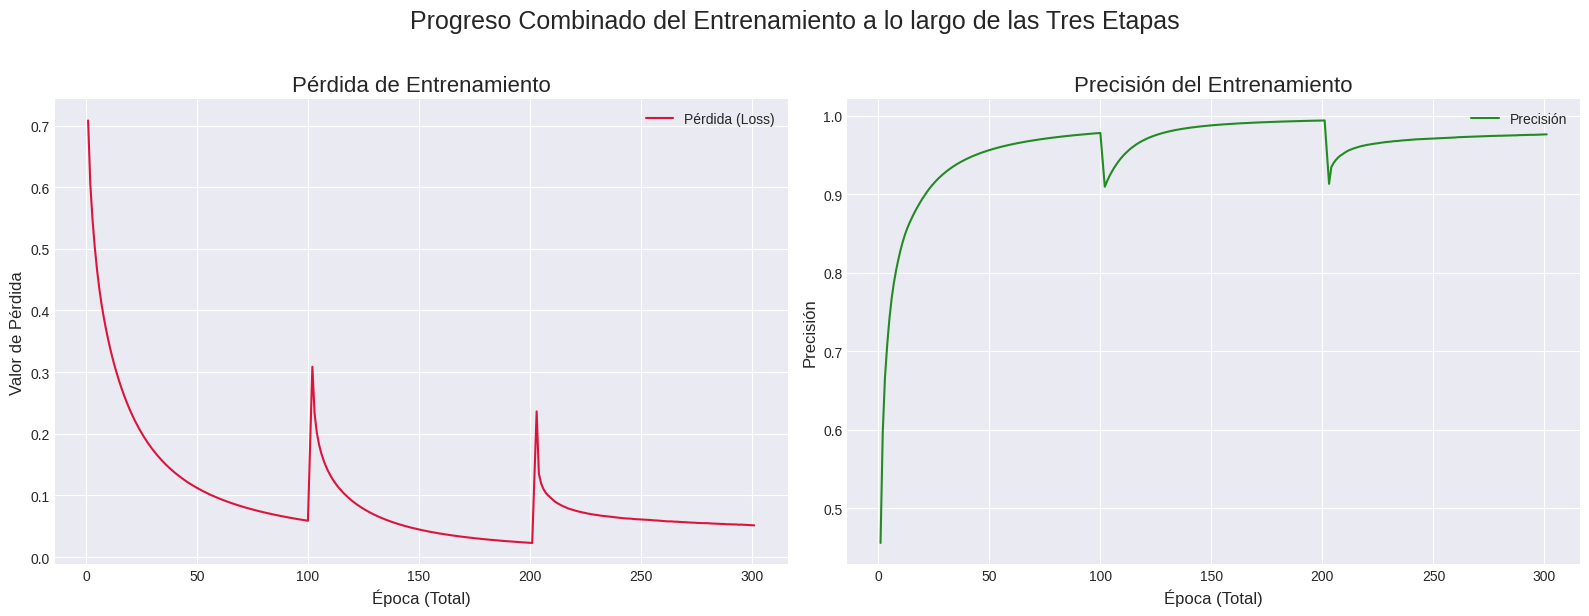

In [ ]:
# --- 1. Definir las rutas de los archivos de historial ---
# Asegúrate de que los archivos existen en estas rutas.
load_history = '/content/drive/MyDrive/Implementacion_Tesis_Drones/A1/logs'

history_paths = {
    'Stage1': os.path.join(load_history, 'training_history_E1_T1.csv'),
    'Stage2': os.path.join(load_history, 'training_history_E2_T1.csv'),
    'Stage3.1': os.path.join(load_history, 'training_history_E3_T1.csv'),
    'Stage3.2': os.path.join(load_history, 'training_history_E3_T2.csv')
}

# --- 2. Cargar y combinar los historiales de entrenamiento ---
combined_history = pd.DataFrame()
current_epoch_offset = 0

print("Cargando historiales de entrenamiento...")

for stage_name, file_path in history_paths.items():
    if os.path.exists(file_path):
        try:
            # Leer el archivo CSV
            history_df = pd.read_csv(file_path)

            # Ajustar los números de época para que sean continuos entre etapas
            if 'epoch' in history_df.columns:
                history_df['epoch'] = history_df['epoch'] + current_epoch_offset
            else:
                # Si no hay columna de 'epoch', crear una basada en el índice
                history_df['epoch'] = history_df.index + current_epoch_offset

            # Concatenar el historial de la etapa actual al historial combinado
            combined_history = pd.concat([combined_history, history_df], ignore_index=True)

            # Actualizar el offset para la siguiente etapa
            current_epoch_offset = combined_history['epoch'].max() + 1

            print(f"Historial de {stage_name} cargado. Total de épocas hasta ahora: {current_epoch_offset-1}")

        except Exception as e:
            print(f"Error al leer el archivo {file_path}: {e}")
    else:
        print(f"¡Advertencia! Archivo no encontrado para {stage_name}: {file_path}")

if combined_history.empty:
    print("\nNo se pudieron cargar los historiales. Por favor, verifica las rutas de los archivos.")
else:
    print("\nTodos los historiales se han combinado exitosamente.")
    print("Resumen del historial combinado:")
    print(combined_history.head())
    print("...")
    print(combined_history.tail())

    # --- 3. Graficar el historial combinado ---
    print("\nGenerando gráficos de pérdida y precisión del entrenamiento...")

    plt.style.use('seaborn-v0_8-darkgrid') # Estilo visual más limpio
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfica de la pérdida
    axes[0].plot(combined_history['epoch'], combined_history['loss'], label='Pérdida (Loss)', color='crimson')
    axes[0].set_title('Pérdida de Entrenamiento', fontsize=16)
    axes[0].set_xlabel('Época (Total)', fontsize=12)
    axes[0].set_ylabel('Valor de Pérdida', fontsize=12)
    axes[0].legend()

    # Gráfica de la precisión (asumiendo que las métricas se llaman 'custom_accuracy' o 'accuracy')
    if 'custom_accuracy' in combined_history.columns:
        axes[1].plot(combined_history['epoch'], combined_history['custom_accuracy'], label='Precisión (Custom)', color='forestgreen')
        axes[1].set_title('Precisión del Entrenamiento', fontsize=16)
        axes[1].set_xlabel('Época (Total)', fontsize=12)
        axes[1].set_ylabel('Precisión (Argmax)', fontsize=12)
        axes[1].legend()
    elif 'accuracy' in combined_history.columns:
        axes[1].plot(combined_history['epoch'], combined_history['accuracy'], label='Precisión', color='forestgreen')
        axes[1].set_title('Precisión del Entrenamiento', fontsize=16)
        axes[1].set_xlabel('Época (Total)', fontsize=12)
        axes[1].set_ylabel('Precisión', fontsize=12)
        axes[1].legend()
    else:
        axes[1].set_title('Precisión no disponible', fontsize=16)
        axes[1].text(0.5, 0.5, 'Datos de precisión no encontrados', transform=axes[1].transAxes,
                     ha='center', va='center', fontsize=10, color='gray')

    fig.suptitle('Progreso Combinado del Entrenamiento a lo largo de las Tres Etapas', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


# Versiones

Versiones de las librerias usadas en este trabajo

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib
import sys

# Mostrar la versión de Python
print(f"Versión de Python: {sys.version.split()[0]}")
print("-" * 40)

# Mostrar versiones de librerías principales
print(f"TensorFlow/Keras: {tf.__version__}")
print(f"NumPy: {np.__version__}")
try:
    print(f"OpenCV (cv2): {cv2.__version__}")
except AttributeError:
    # A veces, Colab instala OpenCV sin el __version__ disponible directamente
    print("OpenCV (cv2): Revisar en el entorno de instalación")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

Versión de Python: 3.12.11
----------------------------------------
TensorFlow/Keras: 2.19.0
NumPy: 2.0.2
OpenCV (cv2): 4.12.0
Pandas: 2.2.2
Matplotlib: 3.10.0


## Imgan base del dron usada en este trabajo

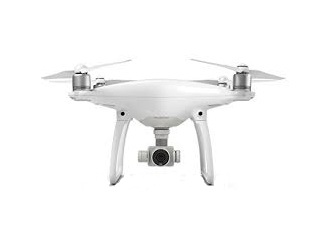